# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config



# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Dataset

In [ ]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/z_reddit_dataset.xlsx")
df.head()

,class,text
0,control,"""Bi women have it easier than bi men"". You ca..."
1,control,Just took five more and added them to the album.
2,control,LO was six months yesterday. He is sitting up ...
3,control,Send emails and make a thread. There is most l...
4,patient,You are not the problem. If you are 18 you don...


In [ ]:
df.shape

(86522, 2)

In [ ]:
df['class'] = df['class'].replace(['patient','control'],[0,1])

In [ ]:
# check class distribution
df['class'].value_counts(normalize = True)

1    0.652424
0    0.347576
Name: class, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'].astype('str'), df['class'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['class'])

# we will use temp_text and temp_labels to create validation and test set
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# # import BERT-base pretrained model
# bert = AutoModel.from_pretrained('gpt2')


# # Load the BERT tokenizer
# tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Load the GPT tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# import GPT pretrained model
gpt_config = GPT2Config.from_pretrained('gpt2', num_classes=2, pad_token=tokenizer.eos_token, pad_token_id=tokenizer.eos_token_id)
gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', config=gpt_config)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # sample data
# text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# # encode text
# sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
tokenizer.pad_token = tokenizer.eos_token
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[5661, 318, 257, 275, 861, 2746, 11808, 50256, 50256, 50256], [732, 481, 3734, 12, 83, 1726, 257, 275, 861, 2746]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

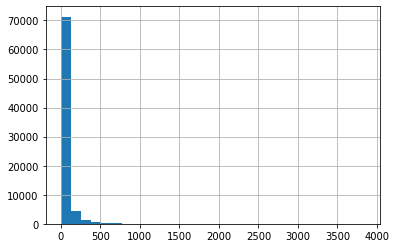

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 200

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# # tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = max_seq_len,
#     pad_to_max_length=True,
#     truncation=True,
#     return_token_type_ids=False
# )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.float32)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.float32)

# # for test set
# test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# # freeze all the parameters
# for param in bert.parameters():
#     param.requires_grad = False

# freeze all the parameters
for name, param in gpt.named_parameters():
    if name in ['transformer.ln_f.weight', 'transformer.ln_f.bias', 'score.weight']:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define Model Architecture

In [ ]:
class GPT_Arch(nn.Module):

    def __init__(self, gpt):
      
      super(GPT_Arch, self).__init__()

      self.gpt = gpt

      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      x = self.gpt(input_ids=sent_id, attention_mask=mask)

      return self.softmax(x[0])

In [ ]:
# pass the pre-trained BERT to our define architecture
model = GPT_Arch(gpt)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-3)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.43855533 0.76636682]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 4

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.long())

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels.long())

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# number of training epochs
epochs = 4

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4
  Batch    50  of  2,434.
  Batch   100  of  2,434.
  Batch   150  of  2,434.
  Batch   200  of  2,434.
  Batch   250  of  2,434.
  Batch   300  of  2,434.
  Batch   350  of  2,434.
  Batch   400  of  2,434.
  Batch   450  of  2,434.
  Batch   500  of  2,434.
  Batch   550  of  2,434.
  Batch   600  of  2,434.
  Batch   650  of  2,434.
  Batch   700  of  2,434.
  Batch   750  of  2,434.
  Batch   800  of  2,434.
  Batch   850  of  2,434.
  Batch   900  of  2,434.
  Batch   950  of  2,434.
  Batch 1,000  of  2,434.
  Batch 1,050  of  2,434.
  Batch 1,100  of  2,434.
  Batch 1,150  of  2,434.
  Batch 1,200  of  2,434.
  Batch 1,250  of  2,434.
  Batch 1,300  of  2,434.
  Batch 1,350  of  2,434.
  Batch 1,400  of  2,434.
  Batch 1,450  of  2,434.
  Batch 1,500  of  2,434.
  Batch 1,550  of  2,434.
  Batch 1,600  of  2,434.
  Batch 1,650  of  2,434.
  Batch 1,700  of  2,434.
  Batch 1,750  of  2,434.
  Batch 1,800  of  2,434.
  Batch 1,850  of  2,434.
  Batch 1,900  of  2,434

In [ ]:
%cp /content/saved_weights.pt /content/gdrive/MyDrive


# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [ ]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = evaluate()[1]
  # preds = model(val_seq.to(device), val_mask.to(device))
  # preds = preds.detach().cpu().numpy()


Evaluating...
  Batch    50  of    271.
  Batch   100  of    271.
  Batch   150  of    271.
  Batch   200  of    271.
  Batch   250  of    271.


In [ ]:
preds

array([[-0.6826679 , -0.70373744],
       [-0.6262786 , -0.76480967],
       [-0.32416043, -1.2842225 ],
       ...,
       [-0.5212752 , -0.90081835],
       [-2.197933  , -0.11769455],
       [-0.39505517, -1.1197631 ]], dtype=float32)

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

         0.0       0.53      0.63      0.57      3008
         1.0       0.78      0.69      0.74      5645

    accuracy                           0.67      8653
   macro avg       0.65      0.66      0.65      8653
weighted avg       0.69      0.67      0.68      8653



In [ ]:
# confusion matrix
pd.crosstab(val_y, preds)

col_0,0,1
row_0,,
0.0,1906,1102
1.0,1723,3922
